In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
data = session.query(Measurement).limit(5).all
data.__dict__
for row in session.query(Measurement).filter(Measurement.date).order_by(Measurement.station).limit(5):
    print(row.__dict__)

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000002E05F8337B8>, 'tobs': 66.0, 'date': '2010-01-01', 'id': 14960, 'prcp': 0.05, 'station': 'USC00511918'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000002E05F833828>, 'tobs': 70.0, 'date': '2010-01-02', 'id': 14961, 'prcp': 0.0, 'station': 'USC00511918'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000002E05F833898>, 'tobs': 75.0, 'date': '2010-01-03', 'id': 14962, 'prcp': 0.0, 'station': 'USC00511918'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000002E05F833908>, 'tobs': 75.0, 'date': '2010-01-04', 'id': 14963, 'prcp': 0.0, 'station': 'USC00511918'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000002E05F833978>, 'tobs': 75.0, 'date': '2010-01-05', 'id': 14964, 'prcp': 0.0, 'station': 'USC00511918'}


# Exploratory Climate Analysis

2017-08-23 2016-08-23


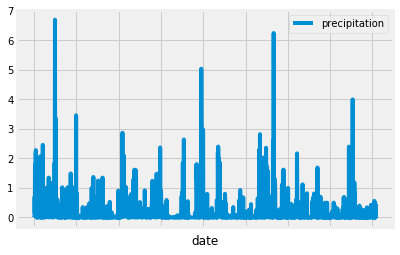

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
data = session.query(Measurement.prcp, Measurement.date).filter(Measurement.date >= "2010-01-01").filter(Measurement.date <= '2010-12-31').all()

# Calculate the date 1 year ago from the last data point in the database
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
date = []
date = list(max_date)
for word in date:
    year = word[0:4]
    month = word[5:7]
    day = word[8:10]
max_date = dt.date(int(year), int(month), int(day))
prev_year = max_date - dt.timedelta(days=365)
print(f'{max_date} {prev_year}')

# Perform a query to retrieve the data and precipitation scores
prcp = []
prcp_date = []
prcp_data = session.query(Measurement.prcp, Measurement.date).\
    filter(Measurement.date >= prev_year).filter(Measurement.date <= max_date)

for row in prcp_data:
    prcp.append(row[0])
    prcp_date.append(row[1])

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame({"date": prcp_date,
                  "precipitation": prcp})

df1 = df.dropna(how='any')
#print(df1.head(100))
df1 = df1.set_index("date")

# Sort the dataframe by date
df1 = df1.sort_values("date")

#print(df1.head(150))

# Use Pandas Plotting with Matplotlib to plot the data
df1.plot(grid=True, rot=0)
plt.show()

![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [13]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station).count()
station_count

9

In [14]:
for row in session.query(Station).order_by(Station.name):
    print(row.__dict__)

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000002E060C89C50>, 'latitude': 21.3152, 'station': 'USC00511918', 'longitude': -157.9992, 'name': 'HONOLULU OBSERVATORY 702.2, HI US', 'id': 8, 'elevation': 0.9}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000002E060C89CC0>, 'latitude': 21.4234, 'station': 'USC00513117', 'longitude': -157.8015, 'name': 'KANEOHE 838.1, HI US', 'id': 2, 'elevation': 14.6}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000002E060C89D30>, 'latitude': 21.5213, 'station': 'USC00514830', 'longitude': -157.8374, 'name': 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 'id': 3, 'elevation': 7.0}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000002E060C89DA0>, 'latitude': 21.3331, 'station': 'USC00516128', 'longitude': -157.8025, 'name': 'MANOA LYON ARBO 785.2, HI US', 'id': 9, 'elevation': 152.4}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000002E

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count = session.query(Station.station, Station.id, func.count(Measurement.id).label('count')).\
            filter(Station.station == Measurement.station).\
            group_by(Station.station, Station.id).\
            order_by(func.count(Station.id).desc())
for row in station_count:
    print(row)

('USC00519281', 7, 2772)
('USC00519397', 1, 2724)
('USC00513117', 2, 2709)
('USC00519523', 6, 2669)
('USC00516128', 9, 2612)
('USC00514830', 3, 2202)
('USC00511918', 8, 1979)
('USC00517948', 4, 1372)
('USC00518838', 5, 511)


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

# Assumption - Most active station = Highest number of observation

# get the first record as the data is in descending order
high_stat_detail = station_count.first()

# get the station name from the detail record
high_station = high_stat_detail[0]
station_stats = session.query(Measurement.id, func.min(Measurement.tobs).label('temp_min'), func.max(Measurement.tobs).label('temp_max'), func.avg(Measurement.tobs).label('temp_avg')).\
            filter(Measurement.station == high_station).\
            group_by(Measurement.id).all()

#for row in station_stats:
#    print(row)

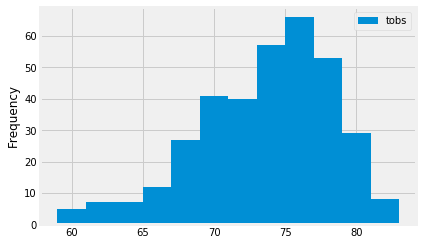

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Assumption - Most active station = Highest number of observation

station_data = session.query(Measurement.tobs).\
            filter(Measurement.station == high_station).\
            filter(Measurement.date >= prev_year).filter(Measurement.date <= max_date).all()

tobs = list(np.ravel(station_data))

fig, ax =plt.subplots()
ax.hist(tobs, bins=12, label="tobs")
ax.legend()
plt.ylabel("Frequency")
plt.show()

![precipitation](Images/station-histogram.png)

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_end_date = '2018-01-01'
year = trip_end_date[0:4]
month = trip_end_date[5:7]
day = trip_end_date[8:10]

trip_end_date = dt.date(int(year), int(month), int(day))
trip_start_date = trip_end_date - dt.timedelta(days=365)

tobs_data = calc_temps(trip_start_date, trip_end_date)
tobs_data = list(np.ravel(tobs_data))
min_tobs = int(tobs_data[0])
avg_tobs = int(tobs_data[1])
max_tobs = int(tobs_data[2])
print(f'{min_tobs} {avg_tobs} {max_tobs}')

58 74 87


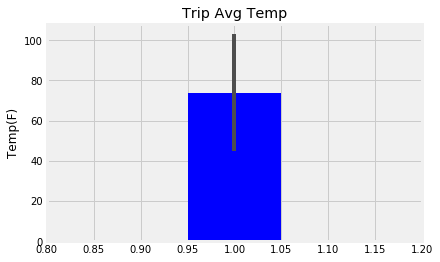

In [47]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots()
index = 1
bar_width = 0.1

error_config = {'ecolor':'0.3'}

ax.bar(index, avg_tobs, bar_width, color='b', yerr=(max_tobs - min_tobs), error_kw=error_config)

ax.set_ylabel('Temp(F)')
ax.set_title('Trip Avg Temp')
ax.set_xlim(0.8,1.2)

# plt.tight_layout()
plt.show()

In [48]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall_data = session.query(Station.station, Station.name, Measurement.prcp, Station.latitude, Station.longitude, Station.elevation).\
            filter(Measurement.station == high_station).\
            filter(Measurement.date >= prev_year).filter(Measurement.date <= max_date).\
            order_by(Measurement.prcp.desc()).all()

rainfall_df = pd.DataFrame(rainfall_data, columns=["Station_ID", "Station_Name", "rainfall_prcp", "Station_Latitude", "Station_Longitude", "Station_Elevation"])

rainfall_df.head()

,Station_ID,Station_Name,rainfall_prcp,Station_Latitude,Station_Longitude,Station_Elevation
0,USC00519397,"WAIKIKI 717.2, HI US",2.98,21.2716,-157.8168,3.0
1,USC00513117,"KANEOHE 838.1, HI US",2.98,21.4234,-157.8015,14.6
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2.98,21.5213,-157.8374,7.0
3,USC00517948,"PEARL CITY, HI US",2.98,21.3934,-157.9751,11.9
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",2.98,21.4992,-158.0111,306.6


## Optional Challenge Assignment

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [25]:
# Plot the daily normals as an area plot with `stacked=False`
